In [7]:
from itertools import takewhile
import matplotlib.pyplot as plt
from matplotlib import animation, cm
import networkx as nx
import numpy as np
import random
from IPython.display import clear_output
plt.rcParams["animation.html"] = "jshtml"

#### You can scroll through this notebook, however many functions are set to save images/animations locally, thus you are better off downloading and running this notebook locally, since Google Colab does not yet save files locally. 

# Definitions of graph topologies

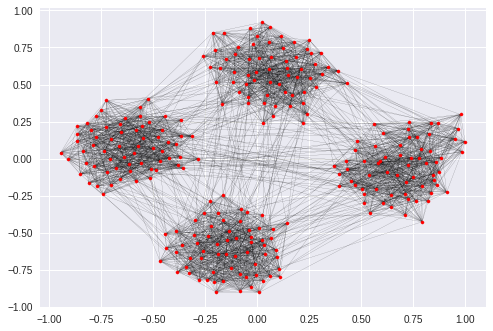

In [52]:
def _init_nodes(g, max_node_value=1000):
    """Initialize all nodes with default values."""
    for i in g.nodes():
        g.node[i]['value'] = random.randint(1, max_node_value)
        g.node[i]['weight'] = 1

        
# Graph generators for different topologies.
        
  
def geometric_graph(amount_nodes):
    g = nx.random_geometric_graph(amount_nodes, 0.1)
    _init_nodes(g)
    return g


def barabasi_graph(amount_nodes, k=2):
    g = nx.barabasi_albert_graph(amount_nodes, k)
    _init_nodes(g)
    return g
  
  
def line_graph(amount_nodes):
    g = nx.path_graph(amount_nodes)
    _init_nodes(g)
    return g


def complete_graph(amount_nodes):
    g = nx.complete_graph(amount_nodes)
    _init_nodes(g)
    return g


def hierarchical_graph(z1, z2, z3, size=256):
    """A hierarchical graph as in P. Sloot's Stochastic Resonance paper."""

    g=nx.empty_graph(size)
    
    group = size // 4
    community = group // 4
    
    z1 = max(1, int(z1 / (256 / size)))
    z2 = max(1, int(z2 / (256 / size)))
    z3 = max(1, int(z3 / (256 / size)))
    assert community * 16 == size
    
    for i in g.node():
        k=random.sample(range(community*(i//community), community*(i//community)+community), z1)
        k+=random.sample(list(range(group*(i//group), community*(i//community)))+list(range(community*(i//community)+community, group*(i//group)+group)), z2)
        k+=random.sample(list(range(0, group*(i//group)))+list(range(group*(i//group)+group, size-1)), z3)
        for j in range(len(k)):
            g.add_edge(i, k[j])
    
    _init_nodes(g)
    return g


# A list of each graph generator and associated name.
graph_gens = [
    (geometric_graph, "Geometric"), (barabasi_graph, "Barabasi"),
    (complete_graph, "Complete")  , (line_graph, "Line"), 
    (lambda amount_nodes: hierarchical_graph(12, 5, 1, amount_nodes), "Hierarchical")
]


# Generate a hierarchical graph and draw it.
g = hierarchical_graph(12, 5, 1, size=256)
nx.draw_networkx(g, with_labels=False, width=0.1, node_size=10)

# Running a simulation

In [39]:
def run_simulation(g, collect, fail, max_timesteps=1000, terminate=None,
                   k_neighbors=1):
    """Simulate Gossip for each timestep and return collected results."""
    
    # Result dictionary <timestep: collect(g)>
    results = dict() 
    results[0] = collect(g)
    
    # Run simulation for each timestep.
    for timestep in range(1, max_timesteps+1):
    # print("Timestep: {}".format(timestep))
      
        # Select the nodes which failed.
        failed_nodes = list(filter(lambda n: fail(g, n, timestep), g.nodes()))
        for node in g.nodes():
            g.node[node]['failed'] = node in failed_nodes
        # TODO: Should they stay failed (permanently removed) and more are born?
        # We tried po
        
        # For each alive node apply Gossip.
        for i in g.nodes():
            _k_neighbors = min(k_neighbors, len(list(g.neighbors(i))))
            k = random.sample(list(g.neighbors(i)), _k_neighbors)
            num_spread = 0
            for j in range(len(k)):
                if k[j] not in failed_nodes:
                    g.node[k[j]]['value'] += 1/(_k_neighbors+1) * g.node[i]['value']
                    g.node[k[j]]['weight'] += 1/(_k_neighbors+1) * g.node[i]['weight']
                    num_spread += 1
                g.node[i]['value'] -= num_spread/(_k_neighbors+1) * g.node[i]['value']
                g.node[i]['weight'] -= num_spread/(_k_neighbors+1) * g.node[i]['weight']
        
        
        # Collect results for this timestep.
        results[timestep] = collect(g)
        
        # Terminate simulation early if termination condition reached.
        # It is necessary to collect the data that is passed to 'terminate'
        # in the way it is indexed below i.e. '[timestep]['terminate']'.
        if terminate and terminate(results, timestep):
            break
      
    return results

In [40]:
N = 256
var_thresh = 0.05
var_timesteps = 5

g = barabasi_graph(N, 2)
expected = np.mean([g.node[i]['value'] for i in g.nodes()])
collect = lambda g: {
    'terminate': [g.node[i]['value'] / g.node[i]['weight'] for i in g.nodes()]
}
fail = lambda _g, _n, _t: random.uniform(0, 1) < 0.1
terminate = lambda results, timestep: timestep > var_timesteps and all([
    np.var(results[t]['terminate']) < expected * var_thresh
    for t in range(max(0, timestep-var_timesteps), timestep+1)
])
results = run_simulation(g, collect, fail, terminate=terminate)

# Variance over time and showing stubborn nodes

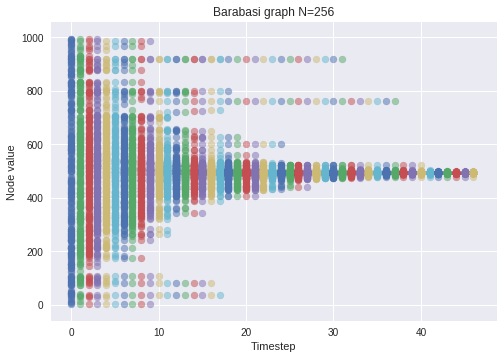

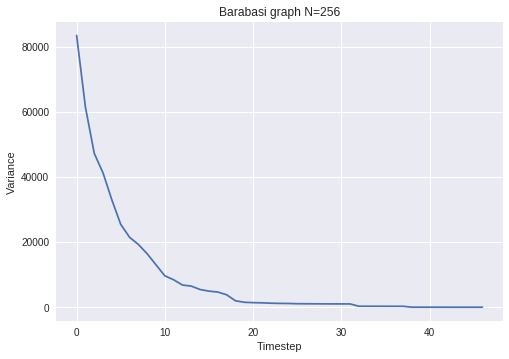

In [41]:
def plot_variance(results, topology, N, save=False):
    """A scatter plot and line graph of variance over time."""
    
    # Scatter/"stubborn" plot of node values over time.
    for timestep in range(len(results)):
        plt.scatter([timestep for _ in g.nodes()], results[timestep]['terminate'], alpha=0.5)
    plt.ylabel('Node value')
    plt.xlabel('Timestep')
    plt.title('{} graph N={}'.format(topology, N))
    if save:
        plt.savefig('{}-stubborness'.format(topology))
        plt.close()
    else:
        plt.show()

    # Variance of node values over time.
    plt.plot(
        range(len(results)),
        [np.var(results[timestep]['terminate']) for timestep in range(len(results))]
    )
    plt.ylabel('Variance')
    plt.xlabel('Timestep')
    plt.title('{} graph N={}'.format(topology, N))
    if save:
        plt.savefig('{}-variance'.format(topology))
        plt.close()
    else:
        plt.show()
    
   
plot_variance(results, "Barabasi", 256)

Run the following code block to generate images like the above for each graph topology, two for each topology. The images will be saved locally.

In [42]:
N = 256
var_thresh = 0.05
var_timesteps = 5

for graph_gen, topology in graph_gens:
    g = graph_gen(N)
    expected = np.mean([g.node[i]['value'] for i in g.nodes()])
    collect = lambda g: {
        'terminate': [g.node[i]['value'] / g.node[i]['weight'] for i in g.nodes()]
    }
    fail = lambda _g, _n, _t: random.uniform(0, 1) < 0.1
    terminate = lambda results, timestep: timestep > var_timesteps and all([
        np.var(results[t]['terminate']) < expected * var_thresh
        for t in range(max(0, timestep-var_timesteps), timestep+1)
    ])
    results = run_simulation(g, collect, fail, terminate=terminate)

    plot_variance(results, topology, N, save=True)

# Animation of Gossip

In [43]:
def _animate_timestep(timestep, results, pos, colors, min_value, max_value):
    """Animate one timestep of a graph as indexed below."""
    nx.draw_networkx(
        results[0]['graph'], node_size=10, with_labels=False, pos=pos,
        node_color=results[timestep]['terminate'], vmin=min_value, vmax=max_value,
        cmap=cm.Spectral
    )

    
def animate_simulation(results, frames, colors):
    """Animate a graph over time."""
    results = {k: v for k, v in filter(lambda kv: kv[0] < frames, results.items())}
    pos = nx.spring_layout(results[0]['graph'])
    anim = animation.FuncAnimation(
        plt.figure(figsize=(15, 8)), _animate_timestep, frames=len(results),
        fargs=(results, pos, colors, np.min(results[0]['terminate']), np.max(results[0]['terminate'])),
        interval=100
    )
    return anim

Run the following code block to generate an animation for each graph topology, showing node values over time. The animations will be saved locally.

In [0]:
N = 512
var_thresh = 0.05
var_timesteps = 5

for graph_gen, topology in graph_gens:
    g = graph_gen(N)
    expected = np.mean([g.node[i]['value'] for i in g.nodes()])
    collect = lambda g: {
        'graph': g,
        'terminate': [g.node[i]['value'] / g.node[i]['weight'] for i in g.nodes()]
    }
    fail = lambda _g, _n, _t: random.uniform(0, 1) < 0.3
    terminate = lambda results, timestep: timestep > var_timesteps and all([
        np.var(results[t]['terminate']) < expected * var_thresh
        for t in range(max(0, timestep-var_timesteps), timestep+1)
    ])
    results = run_simulation(g, collect, fail, terminate=terminate)
    Writer = animation.writers['ffmpeg']
    anim = animate_simulation(results, frames=30)
    anim.save('{}.mp4'.format(topology), writer=Writer(fps=2, bitrate=3200))

# Heatmap of time to network convergence

Complete graph, parameter combination: 9 4, repeat: 2
1000


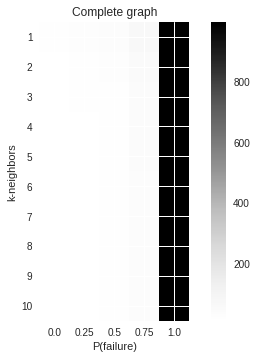

In [11]:
def heatmap(graph_gen, topology, p1s, p2s, p1_name, p2_name,
            k_neighbors=1, prob_failure=0.1, amount_nodes=128,
            repeat=3, var_thresh=0.05, var_timesteps=5):
    """Save a heatmap showing time to convergence of the network in terms of parameters."""
    
    # Run simulations for each combination of parameters.
    image = np.zeros((len(p1s), len(p2s)))
    for index_p1, p1 in enumerate(p1s):
        for index_p2, p2 in enumerate(p2s):
            
            # Assign given parameter values to the correct variables.
            if p1_name == 'k-neighbors':
                k_neighbors = p1
            elif p1_name == 'P(failure)':
                prob_failure = p1
            elif p1_name == 'nodes':
                amount_nodes = p1
            else: raise ValueError('Unknown parameter p1: {}'.format(p1_name))
                
            if p2_name == 'k-neighbors':
                k_neighbors = p2
            elif p2_name == 'P(failure)':
                prob_failure = p2
            elif p2_name == 'nodes':
                amount_nodes = p2
            else: raise ValueError('Unknown parameter p2: {}'.format(p2_name))

            
            # Average results over some repeat runs.
            image_cell_results = []
            for rep in range(repeat):
                
                clear_output(wait=True)
                print("{} graph, parameter combination: {} {}, repeat: {}".format(
                    topology, index_p1, index_p2, rep))
                g = graph_gen(amount_nodes=amount_nodes)
                expected = np.mean([g.node[x]['value'] for x in g.nodes()])
                collect = lambda g: {
                    'graph': g,
                    'terminate': [g.node[x]['value'] / g.node[x]['weight'] for x in g.nodes()]
                }
                fail = lambda _g, _n, _t: random.uniform(0, 1) < prob_failure
                terminate = lambda results, timestep: timestep > var_timesteps and all([
                    np.var(results[t]['terminate']) < expected * var_thresh
                    for t in range(max(0, timestep-var_timesteps), timestep+1)
                ])
                results = run_simulation(g, collect, fail, terminate=terminate, k_neighbors=k_neighbors)
                image_cell_results.append(len(results))
                print(max(results))
            
            image[index_p1][index_p2] = np.mean(image_cell_results)


    plt.close()
    plt.imshow(image, vmax=999)
    plt.title("{} graph".format(topology, amount_nodes))
    plt.ylabel(p1_name)
    plt.xlabel(p2_name)
    plt.xticks(range(len(p2s)), p2s)
    plt.yticks(range(len(p1s)), p1s)
    plt.colorbar()
    plt.savefig('{}-{}={}-{}={}.png'.format(topology, p1_name, p1, p2_name, p2))
    

heatmap(complete_graph, "Complete", np.arange(1, 10+1), np.arange(0, 1.1, 0.25), 'k-neighbors', 'P(failure)')

Run the following code block to generate an image like the above (BUT WITH COLOR!) for each graph topology, showing convergence time as a function of two parameters. The images will be saved locally.

In [45]:
k_neighbor_range = np.arange(1, 11)
failure_range = np.arange(0, 1.1, 0.1)
node_range = [64, 128, 256, 512]


for graph_gen, topology_name in graph_gens:
    heatmap(graph_gen, topology_name, k_neighbor_range, failure_range, 'k-neighbors', 'P(failure)')
    heatmap(graph_gen, topology_name, k_neighbor_range, node_range, 'k-neighbors', 'nodes')
    heatmap(graph_gen, topology_name, failure_range, node_range, 'P(failure)', 'nodes')

# Fraction of nodes converged at each timestep

p1: 9


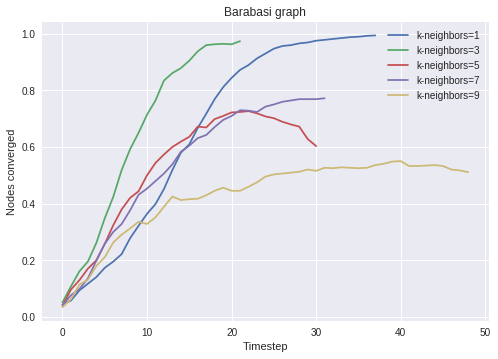

In [6]:
def convergence_density(graph_gen, topology, p1s, p1_name,
                        k_neighbors=1, prob_failure=0.1, amount_nodes=128,
                        repeat=5, var_thresh=0.05, var_timesteps=5):
    """Graph the amount of nodes converged over time, for each parameter value."""
    
    plt.close()
    for index_p1, p1 in enumerate(p1s):
        min_time = np.inf
        all_ys = []
        for _ in range(repeat):
    
            clear_output(wait=True)
            print("p1: {}".format(p1))
    
            # Assign given parameter values to the correct variables.
            if p1_name == 'k-neighbors':
                k_neighbors = p1
            elif p1_name == 'P(failure)':
                prob_failure = p1
            elif p1_name == 'nodes':
                amount_nodes = p1
            else: raise ValueError('Unknown parameter p1: {}'.format(p1_name))
    
            g = graph_gen(amount_nodes=amount_nodes)
            expected = np.mean([g.node[x]['value'] for x in g.nodes()])
            collect = lambda g: {
                'graph': g,                
                'terminate': [g.node[x]['value'] / g.node[x]['weight'] for x in g.nodes()]
            }
            fail = lambda _g, _n, _t: random.uniform(0, 1) < prob_failure
            terminate = lambda results, timestep: timestep > var_timesteps and all([
                np.var(results[t]['terminate']) < expected * var_thresh
                for t in range(max(0, timestep-var_timesteps), timestep+1)
            ])
            results = run_simulation(g, collect, fail, terminate=terminate, k_neighbors=k_neighbors)
            
            # Determine x and y values for this repition of parameter values.
            x = range(len(results))
            y = [
                len(list(filter(
                    lambda x: x > expected * (1-var_thresh) and x < expected * (1+var_thresh),
                    results[timestep]['terminate']
                ))) / len(results[timestep]['terminate'])
                for timestep in x
            ]
            all_ys.append(y)
            min_time = min(min_time, len(results))
            
        # Plot the average y values.
        y = [
            np.mean([all_ys[iy][timestep] for iy in range(len(all_ys))])
            for timestep in range(min_time)
        ]
        plt.plot(range(min_time), y, label='{}={}'.format(p1_name, p1))
        
    plt.legend()
    plt.title('{} graph'.format(topology, amount_nodes))
    plt.ylabel('Nodes converged')
    plt.xlabel('Timestep')
    plt.savefig('{}-{}={}.png'.format(topology, p1_name, p1))


convergence_density(barabasi_graph, 'Barabasi', np.arange(1, 11, 2), 'k-neighbors')

Run the following code block to generate images like the above for each graph topology, three for each topology (varying the x and y parameters in each case). The images will be saved locally.

In [46]:
k_neighbor_range = np.arange(1, 11)
failure_range = np.arange(0, 1.1, 0.1)
node_range = [64, 128, 256, 512]

for graph_gen, topology_name in graph_gens:
    convergence_density(graph_gen, topology_name, k_neighbor_range, 'k-neighbors')
    convergence_density(graph_gen, topology_name, node_range, 'nodes')
    convergence_density(graph_gen, topology_name, failure_range, 'P(failure)')

# Time to system convergence, varying single parameter

p1: 1.05


No handles with labels found to put in legend.


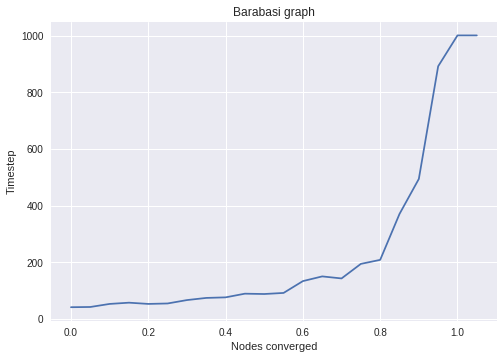

In [58]:
def vary_param(graph_gen, topology, p1s, p1_name,
               k_neighbors=1, prob_failure=0.1, amount_nodes=256,
               repeat=5, var_thresh=0.05, var_timesteps=5):
    """Vary a single parameter, plotting time to convergence against it."""

    plt.close()
    y = []
    for p1 in p1s:
        
        # Repeat the simulation 'repeat' times for this parameter.
        all_results = []
        for _ in range(repeat):

            clear_output(wait=True)
            print("p1: {}".format(p1))

            # Assign given parameter values to the correct variables.
            if p1_name == 'k-neighbors':
                k_neighbors = p1
            elif p1_name == 'P(failure)':
                prob_failure = p1
            elif p1_name == 'nodes':
                amount_nodes = p1
            else: raise ValueError('Unknown parameter p1: {}'.format(p1_name))

            g = graph_gen(amount_nodes=amount_nodes)
            expected = np.mean([g.node[x]['value'] for x in g.nodes()])
            collect = lambda g: {
                'graph': g,
                'terminate': [g.node[x]['value'] / g.node[x]['weight'] for x in g.nodes()]
            }
            fail = lambda _g, _n, _t: random.uniform(0, 1) < prob_failure
            terminate = lambda results, timestep: timestep > var_timesteps and all([
                np.var(results[t]['terminate']) < expected * var_thresh
                for t in range(max(0, timestep-var_timesteps), timestep+1)
            ])
            results = run_simulation(g, collect, fail, terminate=terminate, k_neighbors=k_neighbors)
            all_results.append(results)

        y.append(np.mean([len(results) for results in all_results]))
    
    plt.plot(p1s, y)

    plt.legend()
    plt.title('{} graph'.format(topology, amount_nodes))
    plt.xlabel('Nodes converged')
    plt.ylabel('Timestep')
    plt.savefig('{}-{}={}.png'.format(topology, p1_name, p1))
    

vary_param(barabasi_graph, 'Barabasi', np.arange(0, 1.1, 0.05), 'P(failure)')

In [0]:
k_neighbor_range = np.arange(1, 11)
failure_range = np.arange(0, 1.1, 0.05)
node_range = [64, 128, 256, 512]

for graph_gen, topology_name in graph_gens:
    vary_param(graph_gen, topology_name, failure_range, 'P(failure)')

p1: 0.1


# Time for individual nodes to converge

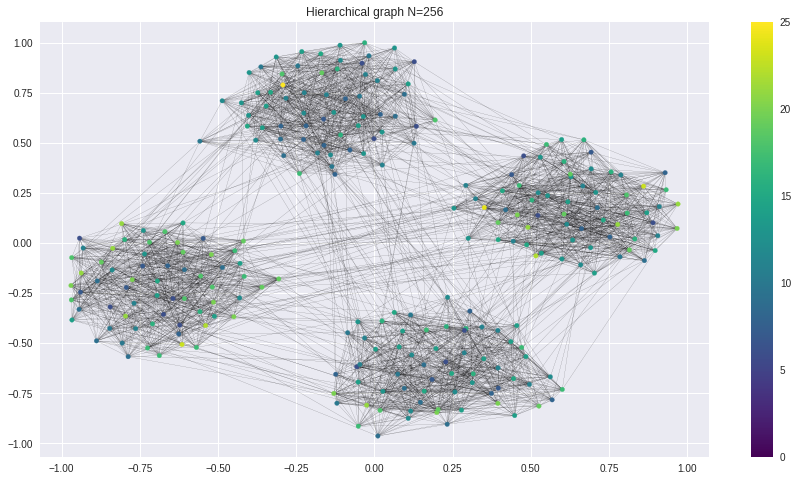

In [55]:
def individual_node_convergence(graph_gen, topology, amount_nodes=256,
                                var_thresh=0.05, var_timesteps=5):
    """Generate the time to converge for each node."""
    g = graph_gen(amount_nodes)
    expected = np.mean([g.node[i]['value'] for i in g.nodes()])
    collect = lambda g: {
        'graph': g,
        'terminate': [g.node[i]['value'] / g.node[i]['weight'] for i in g.nodes()]
    }
    fail = lambda _g, _n, _t: random.uniform(0, 1) < 0.3
    terminate = lambda results, timestep: timestep > var_timesteps and all([
        np.var(results[t]['terminate']) < expected * var_thresh
        for t in range(max(0, timestep-var_timesteps), timestep+1)
    ])
    results = run_simulation(g, collect, fail, terminate=terminate)

    # Modify results into array with timeline for each node.
    nodes_over_time = [
        [results[timestep]['terminate'][x] for timestep in range(len(results))]
        for x in g.nodes()
    ]

    # Set node colors as time for a node to converge.
    node_colors = {}
    for x in g.nodes():
        finished = False
        for timestep in range(len(results)):
            if timestep > 5 and all([
                (nodes_over_time[x][t] > (expected * 0.9) and
                nodes_over_time[x][t] < (expected * 1.1))
                for t in range(max(0, timestep-5), timestep+1)
            ]):
                finished = timestep
                break
        node_colors[x] = finished if finished else 1000
    node_colorss = [node_colors[x] for x in g.nodes()]

    # Histogram of time for nodes to converge.
    plt.close()
    plt.hist(node_colorss)
    plt.xlabel('Timestep')
    plt.ylabel('Nodes')
    plt.title('{} graph N={}'.format(topology, amount_nodes))
    plt.savefig('{}-histogram-indiv-nodes'.format(topology))

    # Show time to converge for each node.
    plt.close()
    cmap = cm.viridis
    vmin = 0
    vmax = max(node_colorss)
    plt.figure(figsize=(15, 8))
    nx.draw_networkx(
        g, node_size=20, with_labels=False, pos=nx.spring_layout(g),
        node_color=node_colorss, cmap=cmap, vmin=vmin, vmax=vmax,
        width=0.1, edgelist=([] if topology == "Complete" else g.edges())
    )
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm)
    plt.title('{} graph N={}'.format(topology, amount_nodes))
    plt.savefig('{}-network-indiv-nodes'.format(topology))

    
individual_node_convergence(graph_gens[-1][0], graph_gens[-1][1])

Run the following code block to generate images like the above for each graph topology (and an associated histogram for each). The images will be saved locally.

In [51]:
for graph_gen, topology in graph_gens:
    individual_node_convergence(graph_gen, topology)

# Push dissemination in Gossip

In [3]:
def msg_or(message1,message2):
    """Checks if an updated message exists."""
    message =[]
    for i in range(len(message1)):
        message.append(message1[i] or message2[i])
    return message


def gen_lineGraph(n,index):
    """Generate a line graph with dissemination attributes."""
    g = nx.path_graph(n)
    for i in g.nodes():
        g.nodes[i]['message']= [False]
        g.nodes[i]['tempo']= g.nodes[i]['message']
        g.nodes[i]['update']= "-"
        g.nodes[i]['tempo-update']= "-"
        
        g.nodes[i]['Active']= True
        g.nodes[i]['view']= list(g.neighbors(i))
        
    g.nodes[index]['message']= [True]
    g.nodes[index]['update']= "update"
    return g

def gen_completeGraph(n,index):
    """Generate a complete graph with dissemination attributes."""
    g = nx.complete_graph(n)
    for i in g.nodes():
        g.nodes[i]['message']= [False]
        g.nodes[i]['tempo']= g.nodes[i]['message']
        g.nodes[i]['update']= "-"
        g.nodes[i]['tempo-update']= "-"
        g.nodes[i]['Active']= True
        g.nodes[i]['view']= list(g.neighbors(i))
        
    g.nodes[index]['message']= [True]
    g.nodes[index]['update']= "update"
    
    return g

def gen_balancedTree(n,depth,index):
    """Generate a balanced tree graph with dissemination attributes."""
    g = nx.balanced_tree(n,depth)
    for i in g.nodes():
        g.nodes[i]['message']= [False]
        g.nodes[i]['update']= "-"
        g.nodes[i]['tempo-update']= "-"
        g.nodes[i]['tempo']= g.nodes[i]['message']
        g.nodes[i]['Active']= False
        g.nodes[i]['view']= list(g.neighbors(i))
    
    g.nodes[index]['message'] = [True]
    g.nodes[index]['update']= "update"
    
    return g

def gen_balancedTree_center(n,depth,index):
    """Generate a line graph with dissemination attributes.
    
    This time the initial message is located at the center of the tree.
    """
    g = nx.balanced_tree(n,depth)
    for i in g.nodes():
        g.nodes[i]['message']= [False]
        g.nodes[i]['update']= "-"
        g.nodes[i]['tempo-update']= "-"
        g.nodes[i]['tempo']= g.nodes[i]['message']
        g.nodes[i]['Active']= False
        g.nodes[i]['view']= list(g.neighbors(i))
    
    center = nx.center(g)[0]
    g.nodes[center]['message'] = [True]
    g.nodes[center]['update']= "update"
    
    return g

In [4]:
def simulation_push(p,q,r,spread_num):
    """Run the Gossip push protocol simulation."""
    global g
    for i in g.nodes():
        

        if (len(g.nodes[i]['view']) > 0 and g.nodes[i]['update'] == "update"):
            g.nodes[i]['update'] == "-"
            #select neighbors
            k_neighbors = min(spread_num, len(g.nodes[i]['view']))
            k = random.sample(list(g.nodes[i]['view']), k_neighbors)        
   
            for j in k:
                neighbour = g.nodes[i]['view'].pop()                 

                #Failure
                if random.random() >= 0:
                    if (msg_or(g.nodes[i]['message'] ,g.nodes[neighbour]['message'] )!=g.nodes[neighbour]['message']): 

                        g.nodes[neighbour]['tempo'] = msg_or(g.nodes[i]['message'],g.nodes[neighbour]['message'])
                        g.nodes[neighbour]['tempo-update'] = "update"  
   
    for i in g.nodes():
        g.nodes[i]['message'] = g.nodes[i]['tempo']
        g.nodes[i]['update'] = g.nodes[i]['tempo-update']
                
    return g

In [5]:
def update_func(t):
    """Run one timestep of the simulation."""
    global f,g
    g = simulation_push(0.001,0.001,0.001,2)
    result =[]
    for i in g.nodes:
        l=0
        for j in g.nodes[i]['message']:
            if j==True:
                l = l+100
        result.append(l)
    f.set_array(np.asarray(result))
    return f,

## This must be run locally, please download first!

/usr/local/lib/python3.6/dist-packages/matplotlib/animation.py:1218: UserWarning: MovieWriter ffmpeg unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


ValueError: ignored

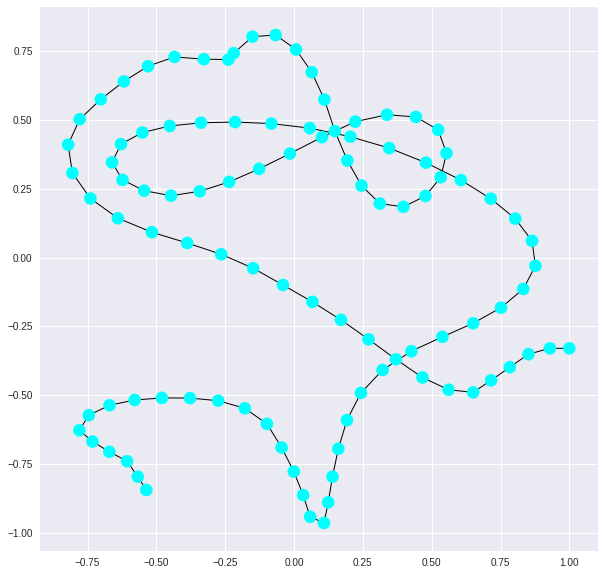

In [8]:
g = gen_lineGraph(100,0)

fig = plt.figure(figsize=(10,10))
pos=nx.spring_layout(g)
    
f = nx.draw_networkx_nodes(g,pos,
                       node_size=150,
                       node_color=np.asarray([0 for i in range(len(g.nodes))]) ,
                       cmap=plt.cm.cool, with_labels=True,vmin=0, vmax=400)

nx.draw_networkx_edges(g,pos,edge_size=1)

anim = animation.FuncAnimation(fig,update_func,frames=50, interval=2000,fargs=())
anim.save("lineG.mp4", fps=1, extra_args=['-vcodec', 'libx264'])